---
# **1. Insallations**
---

In [1]:
!pip install nltk
!pip install --upgrade git+https://github.com/flairNLP/flair.git
!pip install textblob
!pip install stanza
!pip install spacy
!pip install tqdm

  Cloning https://github.com/flairNLP/flair.git to /tmp/pip-req-build-9pvtj6pg
  Running command git clone -q https://github.com/flairNLP/flair.git /tmp/pip-req-build-9pvtj6pg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 798kB 10.1MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 19.7MB 155kB/s 
     |████████████████████████████████| 983kB 57.2MB/s 
     |████████████████████████████████| 276kB 48.0MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 890kB 48.0MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
     |████████████████████████████████| 3.0MB 51.8MB/s 
  Created wheel for flair: filename=flair-0.6.0.post1-cp36-none-any.whl size=200979 sha256=887e0b3dd982ec6ef2aaeb9b796857b8ec34465f319fe0ec20611012f8e4597b
  Stored in directory: /tmp/pip-ephem-wh

---
# **2. Imports**
---

In [2]:
import re
import logging
import requests
import io
import pandas as pd
pd.options.mode.chained_assignment = None # default='warn'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep

In [3]:
from textblob import TextBlob

In [4]:
import flair
flair_sent = flair.models.TextClassifier.load('en-sentiment')

2020-09-21 22:09:58,418 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_3.1.pt not found in cache, downloading to /tmp/tmpdpfqkbb9


100%|██████████| 266147697/266147697 [00:06<00:00, 40589731.27B/s]

2020-09-21 22:10:05,041 copying /tmp/tmpdpfqkbb9 to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2020-09-21 22:10:05,567 removing temp file /tmp/tmpdpfqkbb9
2020-09-21 22:10:05,596 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

SIA = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
import stanza
stanza.download('en', package='ewt', processors='tokenize,sentiment,pos', verbose=True)
stanza.download('en', package='default', processors='tokenize,sentiment', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,sentiment,pos', lang='en', use_gpu=True)

2020-09-21 22:10:24 WARNING: Can not find sentiment: ewt from official model list. Ignoring it.
2020-09-21 22:10:24 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| pretrain  | ewt     |

2020-09-21 22:13:26 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-09-21 22:13:26 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| sentiment | sstplus |
| pretrain  | ewt     |

2020-09-21 22:13:26 INFO: File exists: /root/stanza_resources/en/tokenize/ewt.pt.
2020-09-21 22:13:45 INFO: File exists: /root/stanza_resources/en/pretrain/ewt.pt.
2020-09-21 22:13:45 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-09-21 22:13:45 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tok

---
# **3. NLP functions**
---

In [7]:
def text_blob_subjective(text):
    return TextBlob(text).sentiment

In [8]:
def flair_lstm(text):
    x = flair.data.Sentence(text)
    flair_sent.predict(sentences=x)
    return x.labels

In [9]:
def stanza_funct(text):
    try:
        data = stNLP(text)
        for sentence in data.sentences:
            return sentence.sentiment
    except:
        print('{...}', end='; ')

---
# **4. Preprocessing**
---

Words play a central role in language and thought. Several influential factor analysis studies have shown that
the primary dimensions of word meaning are valence, arousal, and dominance (VAD).
- valence is the positive--negative or pleasure--displeasure dimension; 
- arousal is the excited--calm or active--passive dimension; 
- dominance is the powerful--weak or 'have control'--'have no control' dimension.

```
Each line has the following format:
<AffectCategory><tab><term><tab><score>
<AffectCategory> is one of eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, or disgust).
<term> is a word for which emotion associations are provided.
<score> is a value that indicates the strength of association between the <term> and the <AffectCategory>.
The higher the value, the stronger is the association. Refer to the publications below for details on how the score is calculated.
```


## Loading datasets lexicon

### Donwload datasets to dir

In [10]:
def download_datasets():
    #!mkdir -p datasets
    !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Hashtag-Emotion-Lexicon-v0.2.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-VAD-Lexicon.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/emobank.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/isear.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/checkpoint-bywords.csv -P datasets

In [11]:
# uncomment if you want to download the datasets to ./datasets folder
#download_datasets()

### URLS

In [12]:
NRC_Emotion_Intensity_Lexicon = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Emotion-Intensity-Lexicon-v1.csv'

In [13]:
NRC_Emotion_Lexicon_Wordlevel = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv'

In [14]:
NRC_Hashtag_Emotion_Lexicon = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Hashtag-Emotion-Lexicon-v0.2.csv'

In [15]:
NRC_VAD_Lexicon = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-VAD-Lexicon.csv'

In [16]:
emobank = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/emobank.csv'

In [17]:
isear = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/isear.csv'

In [18]:
url_checkpoint_byWords = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/checkpoint-bywords.csv'

### Requests

In [19]:
def request_csv(url):
    return (requests.get(url).content).decode('utf-8')

### Loading datasets as requests
Anyway the datasets files were downloaded on ./datasets/ folder

In [20]:
df_NRC_Emotion_Intensity = pd.read_csv(io.StringIO(request_csv(NRC_Emotion_Intensity_Lexicon)), sep='\t')

In [21]:
df_NRC_Hashtag = pd.read_csv(io.StringIO(request_csv(NRC_Hashtag_Emotion_Lexicon)), sep='\t')

In [22]:
df_NRC_Emotion_Wordlevel = pd.read_csv(io.StringIO(request_csv(NRC_Emotion_Lexicon_Wordlevel)), sep='\t')

In [23]:
# by sentece
df_isear = pd.read_csv(io.StringIO(request_csv(isear)), sep='|', error_bad_lines=False, usecols=['SIT', 'Field1'])

### Column names & merge (concatenate)

In [24]:
df_NRC_Hashtag.columns = ['category', 'word', 'score']
df_NRC_Emotion_Intensity.columns = ['word', 'category', 'score']
df_NRC_Emotion_Wordlevel.columns = ['word', 'category', 'score']
df_isear.columns = ['category', 'sentence']

In [25]:
df_concat = pd.concat(objs=[df_NRC_Hashtag, df_NRC_Emotion_Intensity, df_NRC_Emotion_Wordlevel], ignore_index=True)

### Sorting concatenated dataset

In [26]:
df_concat = df_concat.sort_values(by=['category'], ascending=True, ignore_index=True)

## Loading datasets Valence Arousal Dominance

In [27]:
# by word
df_NRC_VAD_Lexicon = pd.read_csv(io.StringIO(request_csv(NRC_VAD_Lexicon)), sep='\t')

In [28]:
df_NRC_VAD_Lexicon[df_NRC_VAD_Lexicon['Word'].str.contains('extremely positive', na=False)]

,Word,Valence,Arousal,Dominance
6384,extremely positive,0.993,0.73,0.839


In [29]:
# by sentence 
df_emobank = pd.read_csv(io.StringIO(request_csv(emobank)), sep=',', usecols=['split', 'text', 'V', 'A', 'D'])

### Column names

In [30]:
df_NRC_VAD_Lexicon.columns = ['word', 'Valence', 'Arousal', 'Dominance']
df_emobank.columns = ['split', 'Valence', 'Arousal', 'Dominance', 'sentece']

## Plotters: simple plot & bar

In [31]:
def simple_plot(x, y, size):
    plt.figure(figsize=size)
    plt.plot(x, y, linestyle='solid', color='red')
    plt.xlabel('labels')
    plt.ylabel('scores')
    plt.legend(loc='upper left')
    plt.xticks(size=10, rotation='vertical')
    plt.yticks(size=10)
    plt.grid(b=True)

    plt.show()

def simple_bar(x, y, size):
    plt.figure(figsize=size)
    plt.bar(x, y, linestyle='solid', color='red')
    plt.xlabel('labels')
    plt.ylabel('scores')
    plt.legend(loc='upper left')
    plt.xticks(size=10, rotation='vertical')
    plt.yticks(size=10)
    plt.grid(b=True)

    plt.show()

---
# **5. Preprocessing dataframe concatenated**
---

In [32]:
def preprocessing_characteres(df, c):
    df[c] = df[c].apply(lambda x: re.sub("[^a-zA-Z]", " ", str(x)))
    df[c] = df[c].str.lower()
    df[c] = df[c].apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-zÁ-Úá-ú \t])|(\w+:\/\/\S+)|^rt|http.+?%', '', x))

    return df

In [33]:
df = preprocessing_characteres(df_concat, 'word')

## **NLP applying**

In [34]:
def drop_empty_string(df):
    # Warning: An empty Sentence was created!
    # Are there empty strings in your dataset?
    print('\nremoving empty values...\n')
    nan_value = float('NaN')
    df.replace('', nan_value, inplace=True)
    df.replace(' ', nan_value, inplace=True)
    df.replace('  ', nan_value, inplace=True)
    df.dropna(inplace=True)

    return df

In [35]:
def preprocessing_lexicon(df, c1, c2):
    print('\nRemoving scores equal to 0 & empty or space values\n')
    df.drop(df[df[c1] == 0]. index, inplace=True)
    df.drop(df[df[c2] == float]. index, inplace=True)
    df = drop_empty_string(df)
    
    print('Strip spaces both sides\n')
    df[c2] = df[c2].str.strip()

    return df

In [36]:
def nlp_apply(df, c):
    print('Vader\n')
    df['Compound'] = df[c].apply(lambda x: SIA.polarity_scores(text=x)['compound'])
    
    print('TextBlob')
    df['Subjectivity'] = df[c].apply(lambda x: text_blob_subjective(text=x)[1])
    
    df = drop_empty_string(df)

    print('Stanza')
    df['Stanza'] = df[c].apply(lambda x: stanza_funct(text=x))

    df = drop_empty_string(df)

    print('Flair\n')
    df['Flair'] = df[c].apply(lambda x: ''.join([i.value for i in flair_lstm(text=x)]))

    df = preprocessing_lexicon(df, 'score', 'word')

    return df

In [37]:
!mkdir 'datasets'

In [38]:
# uncomment to apply from the beggining nlp tools & checkpoint
#df = nlp_apply(df, 'word')

In [39]:
# checkpoint
#df.to_csv('datasets/checkpoint-bywords.csv', encoding='utf-8', index=False)

In [40]:
df = pd.read_csv(io.StringIO(request_csv(url=url_checkpoint_byWords)), sep=',')

---
# **6. Preprocessing VAD datasets**
---

### Grouping categories dataset by column value

In [41]:
group = df.groupby(df.category)

In [42]:
positive = group.get_group('positive')
negative = group.get_group('negative')
sadness = group.get_group('sadness')
joy = group.get_group('joy')
trust = group.get_group('trust')
anticipation = group.get_group('anticipation')
anger = group.get_group('anger')
surprise = group.get_group('surprise')
fear = group.get_group('fear')
disgust = group.get_group('disgust')

### Adding VAD columns & filling them with VAD values
http://saifmohammad.com/WebPages/nrc-vad.html

In [43]:
def fill_VAD(df, VAD):
    df.loc[:, 'Valence'] = VAD[0]
    df.loc[:, 'Arousal'] = VAD[1]
    df.loc[:, 'Dominance'] = VAD[2]  
    return  df

In [44]:
positive = fill_VAD(df=positive, VAD=[0.9590, 0.5100, 0.8550])
negative = fill_VAD(df=negative, VAD=[0.1020, 0.5270, 0.1760])
sadness = fill_VAD(df=sadness, VAD=[0.0520, 0.2880, 0.1640])
joy = fill_VAD(df=joy, VAD=[0.9800, 0.8240, 0.7949])
trust = fill_VAD(df=trust, VAD=[0.8880, 0.5470, 0.7410])
anticipation = fill_VAD(df=anticipation, VAD=[0.6980, 0.5390, 0.7110])
anger = fill_VAD(df=anger, VAD=[0.1670, 0.8650, 0.6570])
surprise = fill_VAD(df=surprise, VAD=[0.8750, 0.8750, 0.5620])
fear = fill_VAD(df=fear, VAD=[0.0730, 0.8400, 0.2930])
disgust = fill_VAD(df=disgust, VAD=[0.0520, 0.7750, 0.3170])

### Concatenating & sorting datasets: Categories with Quadrants

In [45]:
def concat(lst):
    df = pd.concat(objs=lst, ignore_index=True)
    return df

In [46]:
df_VAD = df_NRC_VAD_Lexicon

In [47]:
df_VAD = concat([df_VAD, positive])
df_VAD = concat([df_VAD, negative])
df_VAD = concat([df_VAD, sadness])
df_VAD = concat([df_VAD, joy])
df_VAD = concat([df_VAD, trust])
df_VAD = concat([df_VAD, anticipation])
df_VAD = concat([df_VAD, anger])
df_VAD = concat([df_VAD, surprise])
df_VAD = concat([df_VAD, fear])
df_VAD = concat([df_VAD, disgust])

### Delete duplicates & replace NaN with empty

In [48]:
#df_VAD = df_VAD.drop_duplicates(subset=['word'], keep=False)

In [49]:
df_VAD.replace(float('NaN'), '--', inplace=True)

### Applying NLP to VAD dataset

In [50]:
df_VAD = nlp_apply(df_VAD, 'word')

Vader

TextBlob

removing empty values...

Stanza

removing empty values...

Flair


Removing scores equal to 0 & empty or space values


removing empty values...

Strip spaces both sides



In [51]:
#df_VAD = preprocessing_characteres(df_VAD, 'word')
#df_VAD['word'] = df_VAD['word'].str.strip()
#df_VAD = df_VAD.dropna()

### Minimum & max value with midpoint

In [52]:
def min_max_value(df, c):
    return df[c].min(), df[c].max()

In [53]:
def midpoint(df, c):
    '''Compute medium point from dataframe'''
    x1, x2 = min_max_value(df, c)
    return x2 - x1 / 2

In [54]:
df_VAD = preprocessing_characteres(df_VAD, 'word')
df_VAD['word'] = df_VAD['word'].str.strip()
df_VAD = df_VAD.dropna()

In [55]:
# COLUMNS: word, Arousal, Valence, Dominance
arousal_mp = midpoint(df_VAD, 'Arousal')
valence_mp = midpoint(df_VAD, 'Valence')
dominance_mp = midpoint(df_VAD, 'Dominance')

In [56]:
# MIN AND MAX
arousal_min, arousal_max = min_max_value(df_VAD, 'Arousal')
valence_min, valence_max = min_max_value(df_VAD, 'Valence')
dominance_min, dominance_max = min_max_value(df_VAD, 'Dominance')

In [57]:
def midpoint_general(lst_min, lst_max):
    return (max(lst_max) - min(lst_min)) / 2 

In [58]:
midpoint_VAD = midpoint_general(
                                lst_min = [arousal_min, valence_min, dominance_min],
                                lst_max = [arousal_max, valence_max, dominance_max]
                                )

In [59]:
print('Min, Max')
print('Arousal: {}\nValence: {}\nDominance {}\n'.format(min_max_value(df_VAD, 'Arousal'), min_max_value(df_VAD, 'Valence'), min_max_value(df_VAD, 'Dominance')))

print('Medium point')
print('Arousal: {}\nValence: {}\nDominance {}'.format(arousal_mp, valence_mp, dominance_mp))

Min, Max
Arousal: (0.046, 0.99)
Valence: (0.0, 1.0)
Dominance (0.045, 0.991)

Medium point
Arousal: 0.967
Valence: 1.0
Dominance 0.9685


---
# **7.Quadrants**
---

Also we can use:


```python
x_quad = df.query("A <= @midpoint_A and B <= @midpoint_B")
```



In [60]:
midpoint_VAD

0.5

### I. High Arousal, Positive Valence

In [61]:
first_quad =  df_VAD[(df_VAD['Arousal'] >= midpoint_VAD) & (df_VAD['Valence'] >= midpoint_VAD)]

In [62]:
first_quad = first_quad.drop(first_quad[(first_quad['Flair'] == 'NEGATIVE') & (first_quad['Stanza'] == 1)].index)

In [63]:
first_quad['quadrant'] = 1

### II. High Arousal, Negative Valance

In [64]:
second_quad = df_VAD[(df_VAD['Arousal'] >= midpoint_VAD) & (df_VAD['Valence'] <= midpoint_VAD)]

In [65]:
second_quad = second_quad.drop(second_quad[(second_quad['Flair'] == 'POSITIVE') & (second_quad['Stanza'] == 2)].index)

In [66]:
second_quad['quadrant'] = 2

### III. Low Arousal, Negative Valance

In [67]:
third_quad = df_VAD[(df_VAD['Arousal'] <= midpoint_VAD) & (df_VAD['Valence'] <= midpoint_VAD)]

In [68]:
third_quad = third_quad.drop(third_quad[(third_quad['Flair'] == 'POSITIVE') & (third_quad['Stanza'] == 2)].index)

In [69]:
third_quad['quadrant'] = 3

### IV. Low Arousal, Positive Valance

In [70]:
fourth_quad = df_VAD[(df_VAD['Arousal'] <= midpoint_VAD) & (df_VAD['Valence'] >= midpoint_VAD)]

In [71]:
fourth_quad = fourth_quad.drop(fourth_quad[(fourth_quad['Flair'] == 'NEGATIVE') & (fourth_quad['Stanza'] == 1)].index)

In [72]:
fourth_quad['quadrant'] = 4

### PLOT VAD

No handles with labels found to put in legend.


[23900, 30701, 9471, 5671]


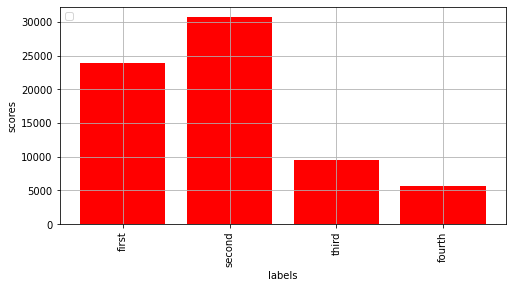

In [73]:
y_quad = list(map(len, [first_quad, second_quad, third_quad, fourth_quad]))

print(y_quad)
simple_bar(['first', 'second', 'third', 'fourth'], y_quad, size=(8, 4))

---
# **8. CATEGORIES**
---
There are four quadrants plus 3D called dominance (README.md)

In [74]:
def find_word(word, df, c='word'):
    return df[df[c].str.contains(word)]

### Confident
- confident -> trust
- unconfident -> disgust

In [75]:
confident = trust

In [76]:
unconfident = disgust

In [77]:
confident['category'] = 'confident'
unconfident['category'] = 'unconfident'

# NOTE
# this where just based on the Wheel of emotions (R. Plutchik)
# as trust and disgust where opposites

### Handles pressure
In the positive side is included patience, focus and calm
- POS : dominance strong + low arousal + positive valence
- NEG : dominance weak + high arousal + negative valence

In [78]:
# Dominance: drop every weak feature
pos_hp = fourth_quad
pos_hp = pos_hp[(pos_hp['Dominance'] >= midpoint_VAD)]

In [79]:
# opposite quadrante (opposite to IV -> II)
neg_hp = second_quad
neg_hp = neg_hp[(neg_hp['Dominance'] <= midpoint_VAD)]

In [80]:
pos_hp['category'] = 'pos hp'
neg_hp['category'] = 'neg hp'

### Organized
- POS : anticipation + high arousal + positive valence   
- NEG : surprise + low arousal + negative valence

In [81]:
organized = concat([anticipation, first_quad])

In [82]:
unorganized = concat([surprise, third_quad])

In [83]:
organized['category'] = 'organized'
unorganized['cateogory'] = 'unorgnized'

### Interested
- POS : [anticipation] + high arousal + positive valence
- NEG : [surprise] + low arousal + negative valence

In [84]:
interested = anticipation

# NOTE
# this where just based on the Wheel of emotions (R. Plutchik)
# as anticipation and surprise where opposites.
# And each events are: 
# vigilance --> anticipation --> [interest]
# amazement --> surprise --> [distraction]

In [85]:
uninterested = surprise

In [86]:
interested['category'] = 'interested'
uninterested['category'] = 'uninterested'

### Happy
- POS : joy + high arousal + positive valence
- NEG : sadness + low arousal + negative valence

In [87]:
happy = joy

In [88]:
unhappy = sadness

In [89]:
happy['category'] = 'happy'
unhappy['category'] = 'unhappy'

### Friendly
- POS : high arousal + positive valence + (positive) + (joy + trust)
- NEG : anger + high arousal + negative valence

In [90]:
friendly = concat([joy, trust, positive])

In [91]:
unfriendly = concat([anger, disgust, negative])

In [92]:
friendly['category'] = 'friendly'
unfriendly['category'] = 'unfriendly'

## Dataset

### Concatenating categories dataframe

In [93]:
categories_datasets = [confident, unconfident, pos_hp, neg_hp, interested, uninterested, happy, unhappy, friendly, unfriendly]
df_categories = concat(categories_datasets)

In [94]:
df_categories.replace(float('NaN'), '--', inplace=True)

### To CSV

In [95]:
df_categories.to_csv('datasets/categories_dataset.csv', encoding='utf-8', index=True)

In [96]:
# drop duplicates: should be for each quadrant
# is not an option
!mkdir 'test'
df_categories_dropdup = df_categories.drop_duplicates(subset=['word'], keep=False, ignore_index=True)
df_categories_dropdup.to_csv('test/categories_set.csv', encoding='utf-8', index=False)

In [97]:
df_categories_dropdup.to_csv('test/categories_set.csv', encoding='utf-8', index=False)

## PLOT Categories

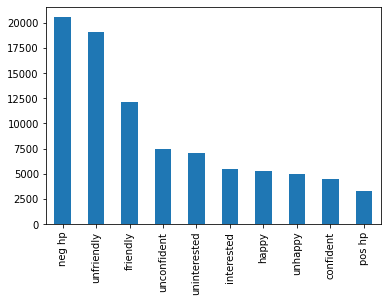

In [98]:
df_categories['category'].value_counts().plot(kind='bar')

#### POSITIVE

No handles with labels found to put in legend.


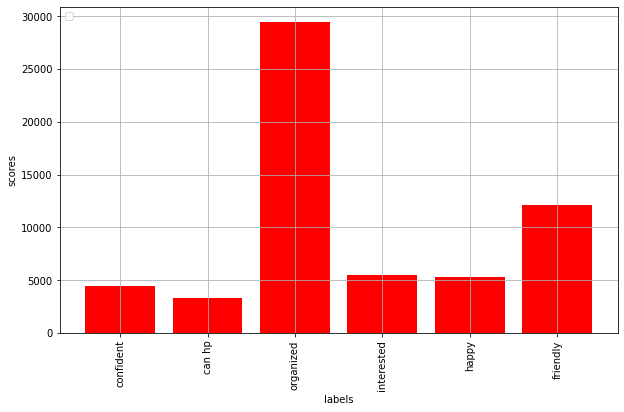

In [99]:
simple_bar(
    x=['confident', 'can hp', 'organized', 'interested', 'happy', 'friendly'],
    y=list(map(len, [confident, pos_hp, organized, interested, happy, friendly])),
    size=(10, 6)
)

#### NEGETIVE

No handles with labels found to put in legend.


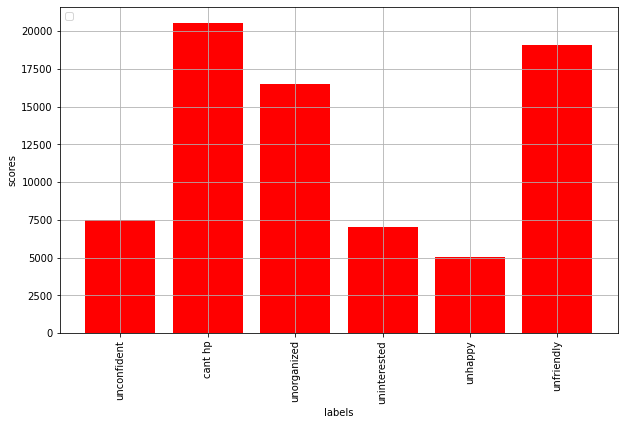

In [100]:
simple_bar(
    x=['unconfident', 'cant hp', 'unorganized', 'uninterested', 'unhappy', 'unfriendly'],
    y=list(map(len, [unconfident, neg_hp, unorganized, uninterested, unhappy, unfriendly])),
    size=(10, 6)
)

# POS (Part Of the Speech)
- using POS from stanza and nltk treebank
- then comparing the results

## Stanza POS

In [101]:
df = df_categories

In [102]:
def stanza_pos(text):
    doc = stNLP(text)
    for sent in doc.sentences:
        for word in sent.words:
            return word.upos

In [103]:
df.replace('', float('NaN'), inplace=True)
df.dropna(subset=['word'], inplace=True)

In [104]:
df['POS stza'] = df['word'].apply(lambda x: stanza_pos(text=x))

## NLTK treebank POS

In [105]:
nltk.download('tagsets')
nltk.download('brown')
nltk.downlozad('universal_tagset')
nltk.download('treebank')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [106]:
nltk.corpus.treebank.tagged_words(tagset='universal')

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ...]

In [113]:
def nltk_pos(text):
    token = word_tokenize(text)
    return (nltk.pos_tag(token)[0])[1]

def get_full_tag_pos(pos_tag):
    tag_dict = {"J": "ADJ",
                "N": "NOUN",
                "V": "VERB",
                "R": "ADV"}
    # assuming pos_tag comes in as capital letters i.e. 'JJR' or 'NN'
    return tag_dict.get(pos_tag[0], 'NOUN') # returns NOUN if the pos_tag[0] doesn't exist in tag_dict

In [120]:
df['POS nlkt'] = df['word'].apply(lambda x: get_full_tag_pos(nltk_pos(text=x)))

In [121]:
df

,category,word,score,Compound,Subjectivity,Stanza,Flair,Valence,Arousal,Dominance,quadrant,POS stza,POS nlkt
0,confident,tolerance,2.63114,0.2960,0.0,1.0,NEGATIVE,0.888,0.547,0.741,--,NOUN,NOUN
1,confident,carry,0.46205,0.0000,0.0,1.0,POSITIVE,0.888,0.547,0.741,--,VERB,NOUN
2,confident,tranquility,1,0.4215,0.0,2.0,POSITIVE,0.888,0.547,0.741,--,NOUN,NOUN
3,confident,socontagious,2.68913,0.0000,0.0,1.0,POSITIVE,0.888,0.547,0.741,--,ADJ,ADJ
4,confident,zeal,1,0.0000,0.0,2.0,NEGATIVE,0.888,0.547,0.741,--,NOUN,NOUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89821,unfriendly,aftermath,1,0.0000,0.0,0.0,POSITIVE,0.102,0.527,0.176,--,NOUN,NOUN
89822,unfriendly,weakened,1,-0.3182,0.0,0.0,NEGATIVE,0.102,0.527,0.176,--,VERB,VERB
89823,unfriendly,imprudent,1,0.0000,0.0,0.0,NEGATIVE,0.102,0.527,0.176,--,ADJ,NOUN
89824,unfriendly,refuse,1,-0.2960,0.0,1.0,NEGATIVE,0.102,0.527,0.176,--,VERB,NOUN


In [122]:
df.to_csv('categories_dataset_v2.csv', encoding='utf-8', index=True)